In [2]:
import itertools
import numpy as np
import copy  # To deep-copy dictionaries
from collections import defaultdict
import matplotlib.pyplot as plt


import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


# Set the random seed for reproducibility
np.random.seed(42)


In [3]:
# Function to calculate values
def calculate_values(M, I, J):
    k = np.ones(len(I))
    c = np.random.uniform(0, 1, len(J))
    lambdas = np.random.uniform(0, 1, len(M))
    util = np.random.uniform(-1, 1, (len(I), len(J)))
    a0 = np.zeros((len(I), len(M)))
    for i in range(len(I)):
        for m in range(len(M)):
            a0[i, m] = (1 / len(M)) ** (1 / lambdas[m])
    alpha = np.random.uniform(0, 1, (len(J), len(M)))
    alpha /= alpha.sum(axis=1, keepdims=True)
    a = np.zeros((len(I), len(J), len(M)))
    for i in range(len(I)):
        for j in range(len(J)):
            for m in range(len(M)):
                a[i, j, m] = (alpha[j, m] * np.exp(util[i, j])) ** (1 / lambdas[m])
    return k, c, lambdas, util, a0, alpha, a


# Define sets based on your data
I = [1]  # Customer segments
J = [1, 2, 3]  # Product candidates
M = [1, 2]  # Nests

k, c, lambdas, util, a0, alpha, a = calculate_values(M, I, J)

V(0, 0) = 0.31416591044451747, nominator = 2.6569805865525606, denominator = 0.8347327250076934
V(0, 1) = 0.011763893672419243, nominator = 5.947958777977594, denominator = 0.0699711546320611
V(0, 0) = 2.6393723727483254, nominator = 0.44082000429453244, denominator = 1.163488140689787
V(0, 1) = 0.0157747892426058, nominator = 5.287276640339337, denominator = 0.08340567466870592
V(0, 0) = 0.3145196558950295, nominator = 2.6544582535260566, denominator = 0.8348792964867363
V(0, 1) = 0.014792890788134252, nominator = 5.425423976846963, denominator = 0.08025770436882214
V(0, 0) = 2.6397261181988374, nominator = 0.4407701467732651, denominator = 1.163512468559723
V(0, 1) = 0.018803786358320813, nominator = 4.9273907500032506, denominator = 0.09265360296702728
V(0, 0) = 0.4005065799244701, nominator = 2.1646617503874763, denominator = 0.866961274341005
V(0, 1) = 0.01200048607073695, nominator = 5.900614609806468, denominator = 0.07081024343376946
V(0, 0) = 2.725713042228278, nominator = 0.4

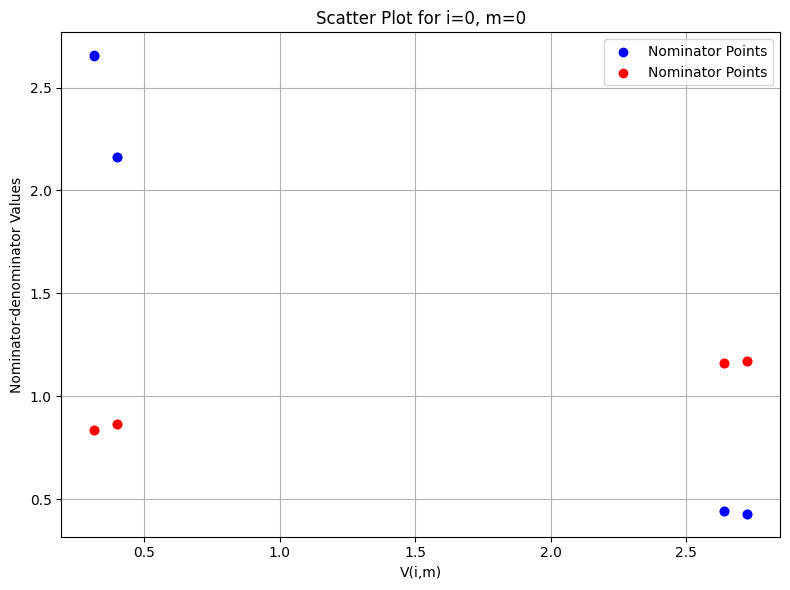

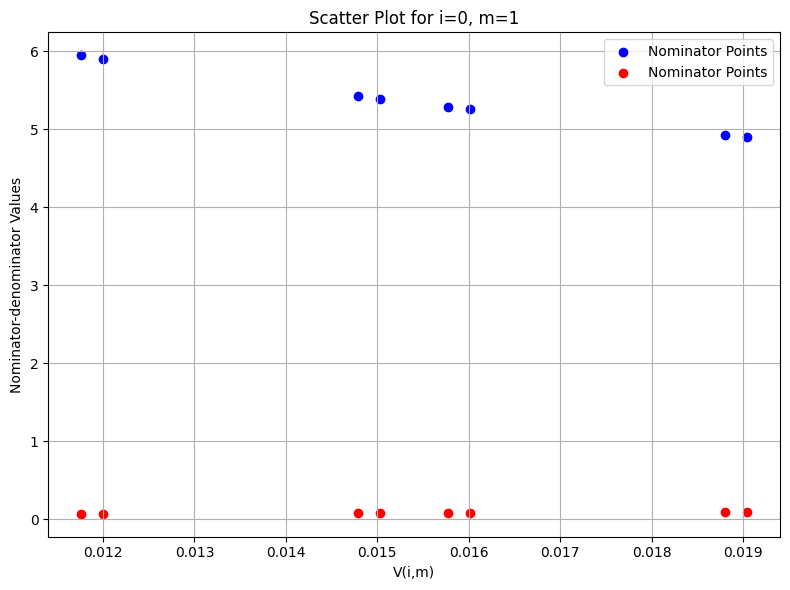

In [6]:
def compute_X_V(Y):
    X = defaultdict(float)
    V = defaultdict(float)
    Z = 0.0

    for i in range(len(I)):
        for m in range(len(M)):
            V[i, m] = a0[i, m] + sum(a[i, j, m] * Y[j + 1] for j in range(len(J)))

    for i in range(len(I)):
        for j in range(len(J)):
            denom = sum(V[i, mm] ** lambdas[mm] for mm in range(len(M)))
            X[i, j] = Y[j + 1] * sum(
                a[i, j, m] * V[i, m] ** (lambdas[m] - 1) / denom for m in range(len(M))
            )

    for i in range(len(I)):
        coeff = k[i]
        for j in range(len(J)):
            Z += coeff * c[j] * X[i, j]

    return X, V, Z


# Lists to store all solutions
all_V = []  # Will store all V dictionaries
all_Z = []  # Will store all Z values
all_numerator = []  # Will store all nomirator V[i, m] ** (lambdas[m] - 1)
all_denominator = []  # Will store all denominators V[i, m] ** (lambdas[m] - 1)

# Generate all possible binary combinations for Y(j) variables
Y_combinations = list(itertools.product([0, 1], repeat=len(J)))

# Enumerate all combinations and compute X, V, and Z
bestSol = float("-inf")
bestY = None
bestX = None
bestV = None

for idx, Y_values in enumerate(Y_combinations):
    Y = {j + 1: Y_values[j] for j in range(len(J))}
    X, V, Z = compute_X_V(Y)

    # Lists to store all solutions
    all_V.append(copy.deepcopy(V))  # Will store all V dictionaries
    all_Z.append(Z)  # Will store all Z values

    if Z > bestSol:
        bestSol = Z
        bestY = Y
        bestX = X
        bestV = V


# Sort V(i, m) for each i across all m based on V(i, m) values
sorted_V_by_m = []
results_with_nominator_denominator = []

for solution_idx, V in enumerate(all_V):  # Iterate over all solutions
    sorted_solution = {}  # Store sorted V for this solution
    nominators = {}  # To store nominators for this solution
    denominators = {}  # To store denominators for this solution
    solution_results = {}
    for (i, m), V_im in V.items():  # Iterate over each (i, m) in V
        lambda_m = lambdas[m - 1]  # Get lambda(m) (adjust for 0-based indexing)

        # Compute nominator and denominator
        nominator = V_im ** (lambda_m - 1)
        denominator = V_im**lambda_m
        print(
            f"V({i}, {m}) = {V_im}, nominator = {nominator}, denominator = {denominator}"
        )
        # Store in dictionaries
        nominators[(i, m)] = nominator
        denominators[(i, m)] = denominator
        # Store in a tuple
        solution_results[(i, m)] = (V_im, nominator, denominator)

    # Append the structured results for this solution
    results_with_nominator_denominator.append(solution_results)
    # Export results_with_nominator_denominator to a text file

    # Append to results
    all_numerator.append(nominators)
    all_denominator.append(denominators)

    # Clean up column names and types

data = pd.DataFrame(
[
    {
        "Solution": solution_idx + 1,
        "i": i,
        "m": m,
        "V(i,m)": V_im,
        "nominator": nominator,
        "denominator": denominator,
    }
    for solution_idx, solution_results in enumerate(
        results_with_nominator_denominator
    )
    for (i, m), (V_im, nominator, denominator) in solution_results.items()
]
)
data = data.dropna()
data["Solution"] = data["Solution"].astype(int)
data["i"] = data["i"].astype(int)
data["m"] = data["m"].astype(int)
data["V(i,m)"] = data["V(i,m)"].astype(float)
data["nominator"] = data["nominator"].astype(float)
data["denominator"] = data["denominator"].astype(float)

# Generate scatter plots for nominator values vs V(i,m) for each i, m combination
for (i, m), group in data.groupby(["i", "m"]):
    plt.figure(figsize=(8, 6))
    plt.scatter(group["V(i,m)"], group["nominator"], color="blue", label="Nominator Points")
    plt.scatter(group["V(i,m)"], group["denominator"], color="red", label="Nominator Points")
    
    # Customize the plot
    plt.title(f"Scatter Plot for i={i}, m={m}")
    plt.xlabel("V(i,m)")
    plt.ylabel("Nominator-denominator Values")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # Show the plot
    plt.show()

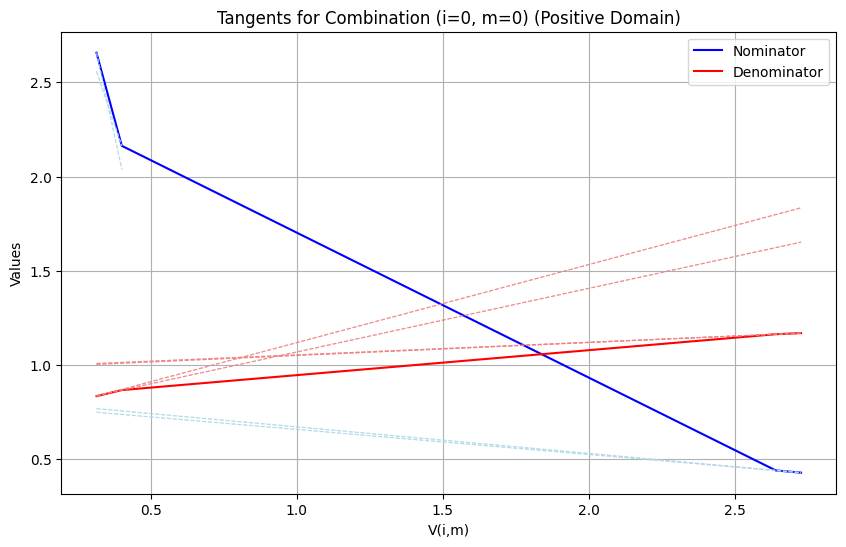

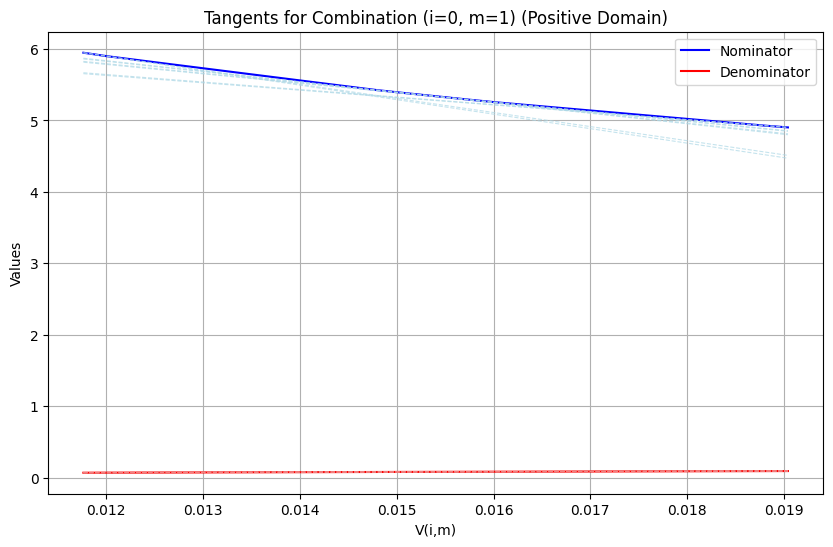

In [11]:
# Recall data and equations
data["lambda_m"] = data["m"].map(lambda m: lambdas[m - 1])  # Add lambda_m to the data


# Function to compute intersection of two tangent lines
def compute_intersection(v1, m1, c1, v2, m2, c2):
    """
    Compute the intersection of two lines.
    :param v1: x-coordinate of point 1
    :param m1: slope of line 1
    :param c1: y-intercept of line 1
    :param v2: x-coordinate of point 2
    :param m2: slope of line 2
    :param c2: y-intercept of line 2
    :return: (x_intersect, y_intersect) or None if not in positive domain
    """
    if m1 == m2:  # Parallel lines
        return None
    x_intersect = (c2 - c1 + m1 * v1 - m2 * v2) / (m1 - m2)
    y_intersect = m1 * (x_intersect - v1) + c1

    # Restrict to positive domain
    if x_intersect > 0 and y_intersect > 0:
        return x_intersect, y_intersect
    return None


# Data for intersections
intersection_results = []

# Iterate over each (i, m) combination
for (i, m), group in data.groupby(["i", "m"]):
    group = group.sort_values(by="V(i,m)")  # Sort by V(i,m)
    x = group["V(i,m)"].values
    nominator = group["nominator"].values
    denominator = group["denominator"].values
    lambda_m = group["lambda_m"].iloc[0]  # Get lambda for this group

    # Compute derivatives for tangent lines
    nominator_slopes = (lambda_m - 1) * x ** (lambda_m - 2)
    denominator_slopes = lambda_m * x ** (lambda_m - 1)

    # Compute intersections between tangent lines for nominator
    for idx1 in range(len(x)):
        for idx2 in range(idx1 + 1, len(x)):
            v1, m1, c1 = x[idx1], nominator_slopes[idx1], nominator[idx1]
            v2, m2, c2 = x[idx2], nominator_slopes[idx2], nominator[idx2]
            intersection = compute_intersection(v1, m1, c1, v2, m2, c2)
            if intersection:
                intersection_results.append(
                    {
                        "i": i,
                        "m": m,
                        "curve": "nominator",
                        "x_intersect": intersection[0],
                        "y_intersect": intersection[1],
                    }
                )

    # Compute intersections between tangent lines for denominator
    for idx1 in range(len(x)):
        for idx2 in range(idx1 + 1, len(x)):
            v1, m1, c1 = x[idx1], denominator_slopes[idx1], denominator[idx1]
            v2, m2, c2 = x[idx2], denominator_slopes[idx2], denominator[idx2]
            intersection = compute_intersection(v1, m1, c1, v2, m2, c2)
            if intersection:
                intersection_results.append(
                    {
                        "i": i,
                        "m": m,
                        "curve": "denominator",
                        "x_intersect": intersection[0],
                        "y_intersect": intersection[1],
                    }
                )

# Convert results to a DataFrame
intersection_df = pd.DataFrame(intersection_results)

def compute_positive_tangent(x_values, x_point, y_value, derivative):
    """
    Compute the tangent line, limited to positive x and y domain.
    :param x_values: Array of x values for plotting
    :param x_point: The x value where the tangent is computed
    :param y_value: The y value at x_point
    :param derivative: The derivative at x_point
    :return: Tangent line y-values, clipped to positive domain
    """
    tangent = derivative * (x_values - x_point) + y_value
    tangent[tangent < 0] = np.nan  # Exclude negative y-values
    tangent[x_values <= 0] = np.nan  # Exclude non-positive x-values
    return tangent



for (i, m), group in data.groupby(["i", "m"]):
    group = group.sort_values(by="V(i,m)")  # Sort by V(i,m)
    x = group["V(i,m)"]
    nominator = group["nominator"]
    denominator = group["denominator"]
    lambda_m = group["lambda_m"].iloc[0]  # Get lambda for this group

    # Compute derivatives
    nominator_derivative = (lambda_m - 1) * x ** (lambda_m - 2)
    denominator_derivative = lambda_m * x ** (lambda_m - 1)

    # Plot curves
    plt.figure(figsize=(10, 6))
    plt.plot(x, nominator, label="Nominator", color="blue")
    plt.plot(x, denominator, label="Denominator", color="red")

    # Plot tangent lines for nominator
    for v, nom, der in zip(x, nominator, nominator_derivative):
        tangent = compute_positive_tangent(x, v, nom, der)
        plt.plot(x, tangent, "--", color="lightblue", alpha=0.7, linewidth=0.8)

    # Plot tangent lines for denominator
    for v, den, der in zip(x, denominator, denominator_derivative):
        tangent = compute_positive_tangent(x, v, den, der)
        plt.plot(x, tangent, "--", color="lightcoral", alpha=0.7, linewidth=0.8)

    # Labels and legend
    plt.title(f"Tangents for Combination (i={i}, m={m}) (Positive Domain)")
    plt.xlabel("V(i,m)")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)



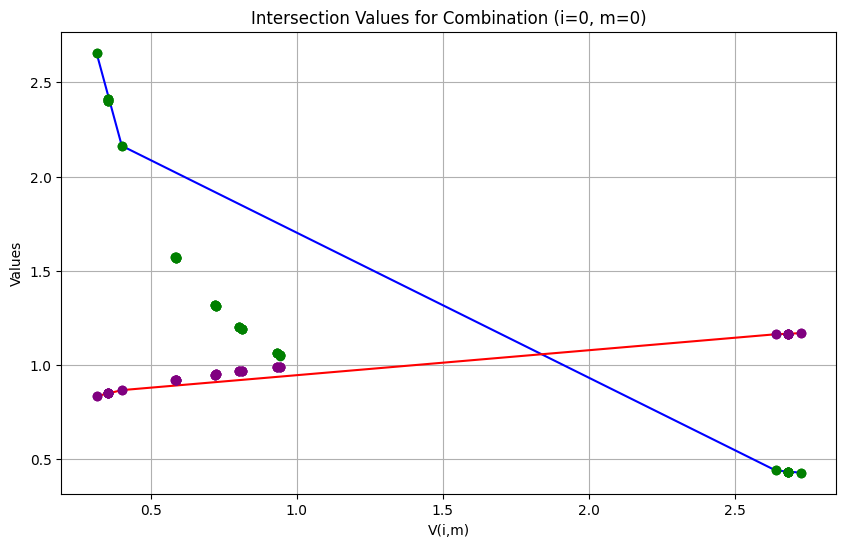

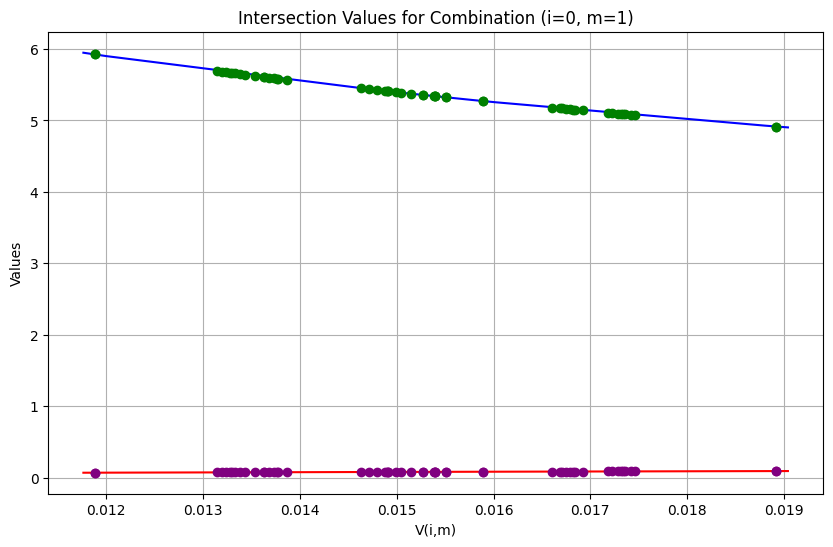

In [16]:
# Compute nominator and denominator for intersection points
intersection_results_with_values = []

for _, row in intersection_df.iterrows():
    x_intersect = row["x_intersect"]
    i, m = row["i"], row["m"]
    lambda_m = lambdas[m - 1]  # Retrieve lambda_m

    # Compute nominator and denominator
    if x_intersect > 0:  # Ensure positive domain
        nominator_value = x_intersect ** (lambda_m - 1)
        denominator_value = x_intersect**lambda_m
        intersection_results_with_values.append(
            {
                "i": i,
                "m": m,
                "x_intersect": x_intersect,
                "y_intersect": row["y_intersect"],
                "nominator": nominator_value,
                "denominator": denominator_value,
            }
        )

# Convert to DataFrame
intersection_with_values_df = pd.DataFrame(intersection_results_with_values)


for (i, m), group in data.groupby(["i", "m"]):
        group = group.sort_values(by="V(i,m)")
        x = group["V(i,m)"]
        nominator = group["nominator"]
        denominator = group["denominator"]

        # Filter intersections for this (i, m)
        intersections = intersection_with_values_df[
            (intersection_with_values_df["i"] == i)
            & (intersection_with_values_df["m"] == m)
        ]

        plt.figure(figsize=(10, 6))
        plt.plot(x, nominator, label="Nominator", color="blue")
        plt.plot(x, denominator, label="Denominator", color="red")

        # Plot intersection points
        for _, row in intersections.iterrows():
            plt.scatter(
                row["x_intersect"],
                row["nominator"],
                color="green",
                label="Nominator Value",
                zorder=5,
            )
            plt.scatter(
                row["x_intersect"],
                row["denominator"],
                color="purple",
                label="Denominator Value",
                zorder=5,
            )

        # Labels and legend
        plt.title(f"Intersection Values for Combination (i={i}, m={m})")
        plt.xlabel("V(i,m)")
        plt.ylabel("Values")
        #plt.legend()
        plt.grid(True)



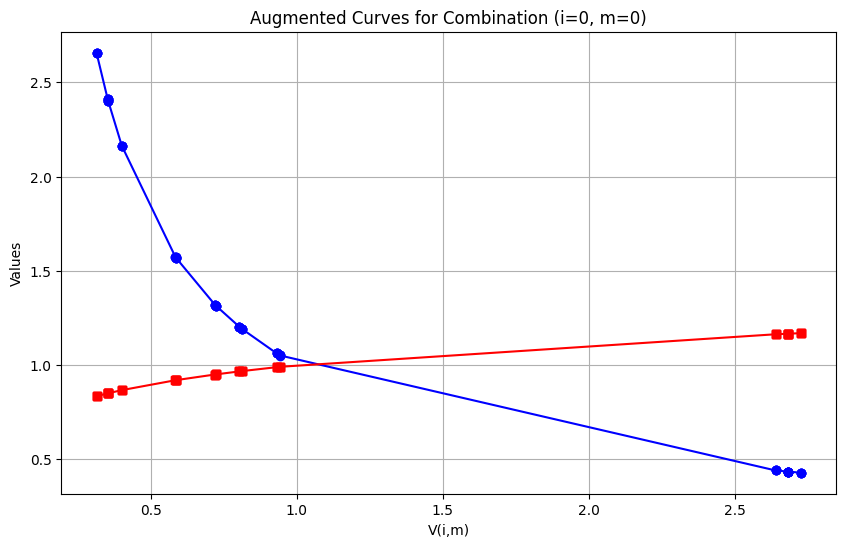

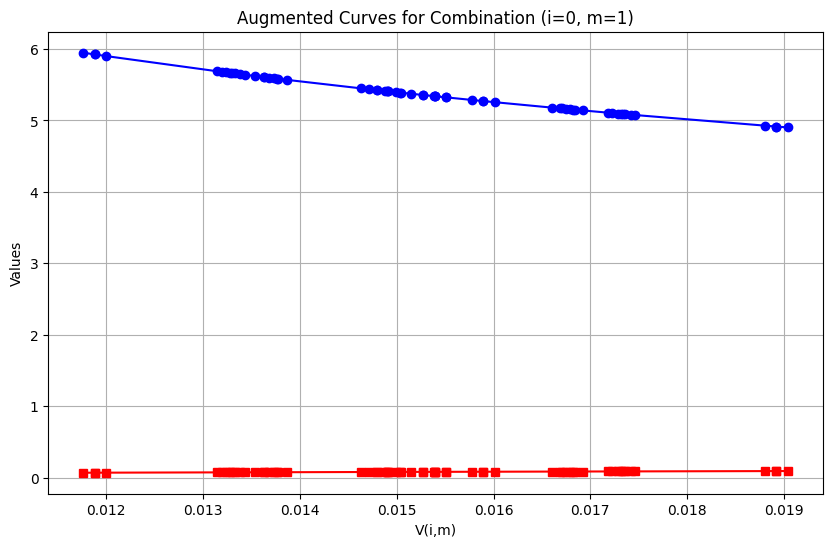

In [18]:
# Augment the data with intersection points
augmented_data = []

for (i, m), group in data.groupby(["i", "m"]):
    group = group.sort_values(by="V(i,m)")
    original_v = group["V(i,m)"].values
    lambda_m = lambdas[m - 1]  # Get lambda for this group

    # Original points
    for v in original_v:
        augmented_data.append(
            {
                "i": i,
                "m": m,
                "V(i,m)": v,
                "nominator": v ** (lambda_m - 1),
                "denominator": v**lambda_m,
            }
        )

    # Intersection points
    intersections = intersection_with_values_df[
        (intersection_with_values_df["i"] == i)
        & (intersection_with_values_df["m"] == m)
    ]
    for _, row in intersections.iterrows():
        v = row["x_intersect"]
        augmented_data.append(
            {
                "i": i,
                "m": m,
                "V(i,m)": v,
                "nominator": v ** (lambda_m - 1),
                "denominator": v**lambda_m,
            }
        )

# Convert to DataFrame and sort
augmented_df = pd.DataFrame(augmented_data)
augmented_df = augmented_df.sort_values(by=["i", "m", "V(i,m)"]).reset_index(drop=True)

# Visualization

for (i, m), group in augmented_df.groupby(["i", "m"]):
    group = group.sort_values(by="V(i,m)")
    x = group["V(i,m)"]
    nominator = group["nominator"]
    denominator = group["denominator"]

    plt.figure(figsize=(10, 6))
    plt.plot(x, nominator, label="Nominator (Augmented)", color="blue", marker="o")
    plt.plot(
        x, denominator, label="Denominator (Augmented)", color="red", marker="s"
    )

    # Labels and legend
    plt.title(f"Augmented Curves for Combination (i={i}, m={m})")
    plt.xlabel("V(i,m)")
    plt.ylabel("Values")
    plt.grid(True)

